# One Compartment (Single Pool) Model

The One Compartment Model assumes that a substance (drug, pollutant, tracer) enters a system and is instantaneously mixed throughout a single, uniform volume.

### 1. The Differential Equation
The model is based on the Mass Balance principle:
$$\text{Rate of Change} = \text{Input Rate} - \text{Output Rate}$$

Mathematically:
$$\frac{dA}{dt} = R_{in} - k_{el} A$$

Where:
* $A(t)$ is the Amount of substance in the pool.
* $R_{in}$ is the zero-order input rate (e.g., IV infusion, constant pollution source).
* $k_{el}$ is the first-order elimination rate constant (fraction removed per time unit).

### 2. Analytical Solutions
**Scenario A: IV Bolus (Single Shot)**
$R_{in} = 0$, initial amount $A_0$:
$$A(t) = A_0 e^{-k_{el}t}$$

**Scenario B: Constant Infusion (Accumulation)**
Constant $R_{in}$, initial amount $0$:
$$A(t) = \frac{R_{in}}{k_{el}} (1 - e^{-k_{el}t})$$
The system approaches a **Steady State** where Input = Output: $A_{ss} = \frac{R_{in}}{k_{el}}$.

### 3. Half-Life
The time required for the amount to decrease by 50%:
$$t_{1/2} = \frac{\ln(2)}{k_{el}} \approx \frac{0.693}{k_{el}}$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')

def one_compartment_model(A, t, R_in, k_el):
    """
    dA/dt = Input - Output
    """
    # Output is proportional to current amount (First Order)
    dA_dt = R_in - (k_el * A)
    return dA_dt

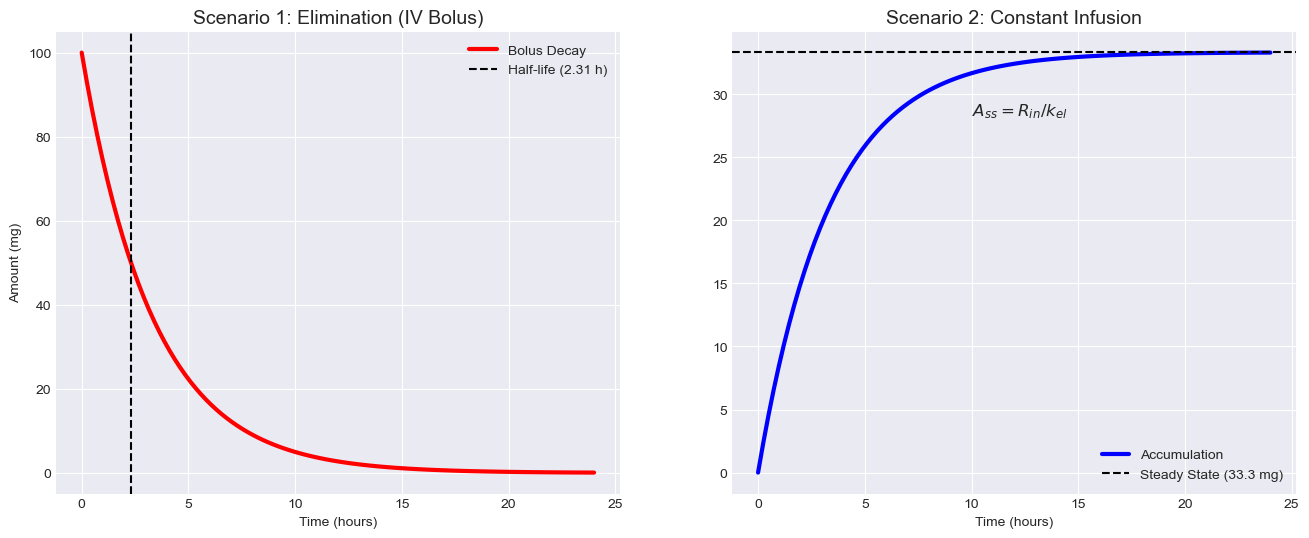

In [3]:
# --- Parameters ---
t = np.linspace(0, 24, 100) # 24 hours
k_el = 0.3                  # Elimination rate (units: 1/hr)
half_life = np.log(2) / k_el

# --- Scenario 1: IV Bolus (Input=0, Initial=100mg) ---
R_in_bolus = 0
A0_bolus = 100
sol_bolus = odeint(one_compartment_model, A0_bolus, t, args=(R_in_bolus, k_el))

# --- Scenario 2: Constant Infusion (Input=10mg/hr, Initial=0) ---
R_in_infusion = 10
A0_infusion = 0
sol_infusion = odeint(one_compartment_model, A0_infusion, t, args=(R_in_infusion, k_el))

# Calculate Theoretical Steady State
A_ss = R_in_infusion / k_el

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Bolus
ax1.plot(t, sol_bolus, 'r-', linewidth=3, label='Bolus Decay')
ax1.axvline(half_life, color='k', linestyle='--', label=f'Half-life ({half_life:.2f} h)')
ax1.set_title('Scenario 1: Elimination (IV Bolus)', fontsize=14)
ax1.set_ylabel('Amount (mg)')
ax1.set_xlabel('Time (hours)')
ax1.legend()

# Plot 2: Infusion
ax2.plot(t, sol_infusion, 'b-', linewidth=3, label='Accumulation')
ax2.axhline(A_ss, color='k', linestyle='--', label=f'Steady State ({A_ss:.1f} mg)')
ax2.text(10, A_ss - 5, r'$A_{ss} = R_{in} / k_{el}$', fontsize=12)
ax2.set_title('Scenario 2: Constant Infusion', fontsize=14)
ax2.set_xlabel('Time (hours)')
ax2.legend()

plt.show()

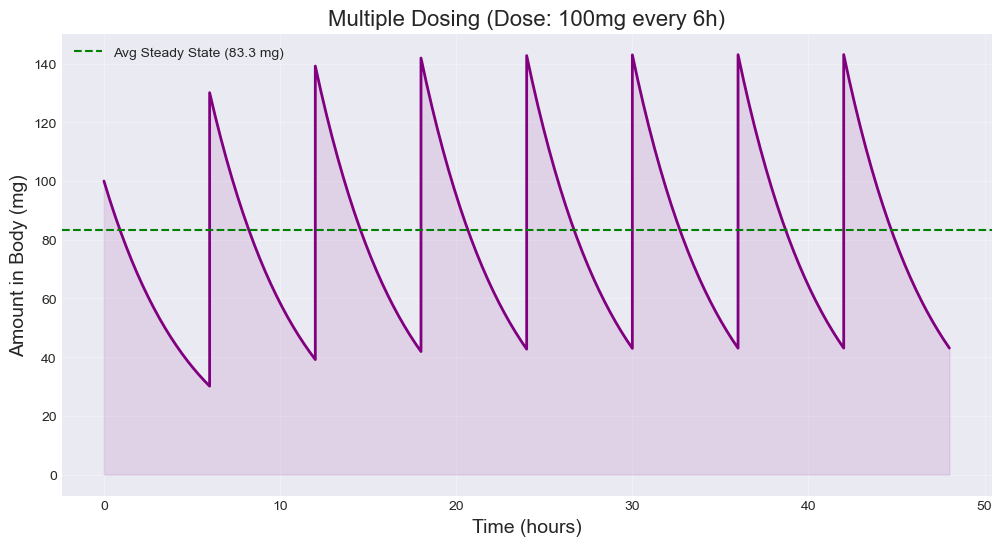

In [4]:
# --- Parameters ---
k_el = 0.2
dose_amount = 100     # mg per dose
interval = 6          # hours between doses
n_doses = 8           # total doses

# Create a custom time array that resets every interval
full_time = []
full_conc = []

current_amount = 0
current_time = 0

for i in range(n_doses):
    # 1. Add Dose
    current_amount += dose_amount
    
    # 2. Simulate decay for the interval duration
    t_segment = np.linspace(current_time, current_time + interval, 20)
    sol = odeint(one_compartment_model, current_amount, t_segment, args=(0, k_el))
    
    # 3. Store results
    full_time.extend(t_segment)
    full_conc.extend(sol.flatten())
    
    # 4. Update for next loop
    current_amount = sol[-1][0] # The amount at the end of the interval
    current_time += interval

# --- Plotting ---
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(full_time, full_conc, 'purple', linewidth=2)
ax.fill_between(full_time, full_conc, color='purple', alpha=0.1)

# Average Steady State Line
avg_ss = (dose_amount / interval) / k_el
ax.axhline(avg_ss, color='green', linestyle='--', label=f'Avg Steady State ({avg_ss:.1f} mg)')

ax.set_title(f'Multiple Dosing (Dose: {dose_amount}mg every {interval}h)', fontsize=16)
ax.set_xlabel('Time (hours)', fontsize=14)
ax.set_ylabel('Amount in Body (mg)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

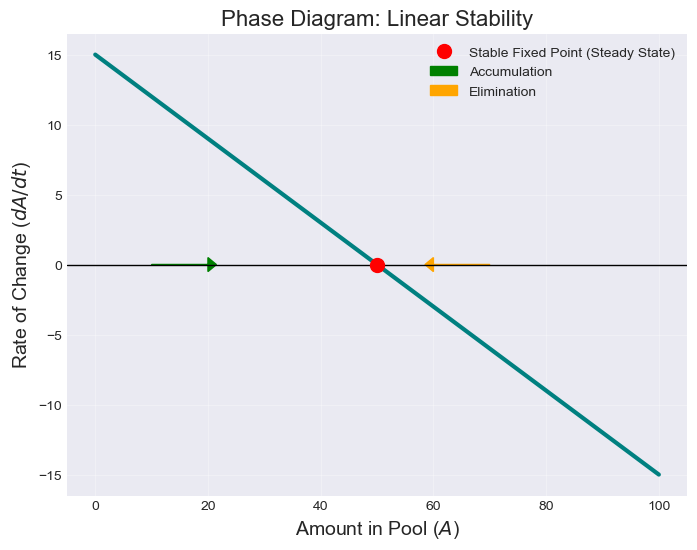

In [5]:
# --- Parameters ---
A_phase = np.linspace(0, 100, 100)
k_phase = 0.3
R_in_phase = 15 # Constant input

# Rate of change
dA_dt = R_in_phase - (k_phase * A_phase)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(A_phase, dA_dt, color='teal', linewidth=3)
ax.axhline(0, color='black', linewidth=1)

# Fixed Point
fixed_point = R_in_phase / k_phase
ax.plot(fixed_point, 0, 'ro', markersize=10, label='Stable Fixed Point (Steady State)')

# Flow arrows
ax.arrow(10, 0, 10, 0, head_width=1, fc='green', ec='green', label='Accumulation')
ax.arrow(fixed_point + 20, 0, -10, 0, head_width=1, fc='orange', ec='orange', label='Elimination')

ax.set_title('Phase Diagram: Linear Stability', fontsize=16)
ax.set_xlabel('Amount in Pool ($A$)', fontsize=14)
ax.set_ylabel('Rate of Change ($dA/dt$)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

In [6]:
def analyze_compartment(k, Volume=None, Clearance=None):
    """
    Calculates PK parameters based on elimination rate k.
    """
    print(f"{'-'*30}")
    print(f"One Compartment Analysis")
    print(f"{'-'*30}")
    
    half_life = 0.693 / k
    print(f"Elimination Rate (k): {k} /hr")
    print(f"Half-Life (t1/2):       {half_life:.2f} hr")
    print(f"Time to Steady State:   {half_life * 5:.2f} hr (approx 5 half-lives)")
    
    if Volume and Clearance is None:
        Cl = k * Volume
        print(f"Volume of Dist (Vd):    {Volume} L")
        print(f"Clearance (Cl):         {Cl:.2f} L/hr")
        
    print("\n")

analyze_compartment(k=0.15, Volume=50)

------------------------------
One Compartment Analysis
------------------------------
Elimination Rate (k): 0.15 /hr
Half-Life (t1/2):       4.62 hr
Time to Steady State:   23.10 hr (approx 5 half-lives)
Volume of Dist (Vd):    50 L
Clearance (Cl):         7.50 L/hr


